# Text classification multi-class

### Imports for data preprocessing, visualisation and saving the model

In [1]:
import pandas as pd
import nltk
from nltk import RegexpTokenizer
import unicodedata
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from joblib import dump
import pickle

### Imports for data vectorisation, training and model evaluation

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

### Get data

In [3]:
df = pd.read_csv('../data/training_data.csv', sep=';')
# df.head()
print(len(df))

6018


### Data preprocessing

In [4]:
def get_conversation(string: str):
    """
    input: the conversation (list of lists with many infomations : author, time, message)
    output: the conversation (str format)
    retrieves each message from the list of lists to reform the conversation and returns it in a single string format
    """
    if type(string)==str:
        liste = eval(string)
    elif type(string)==list:
        liste = string
    else:
        return None
    conversation = []
    for it in liste:
        msg = it[3]
        msg = ''.join(msg.split(': ')[1:]).strip()
        conversation.append(msg)
    res = ' '.join(conversation).strip()
    return res

def find_label(tags: list):
    """
    input: a list of tags
    output: the label (string format)
    finds the label of the conversation
    """
    if 'loa' in tags or 'lld' in tags or 'location' in tags:
        return 'location'
    elif 'occasion' in tags:
        return 'vo'
    elif 'neuf' in tags:
        return 'vn'
    elif 'entretien' in tags or 'service' in tags or 'apv' in tags:
        return 'apv'
    else:
        return None
    
def clean_text(text):
    """
    input: str
    output: list
    A simple function to clean up the data. All the words that
    are not designated as a stop word is then lemmatized after
    encoding and basic regex parsing are performed.
    """
    wnl = nltk.stem.WordNetLemmatizer()
    tokenizer = RegexpTokenizer(r'''\w'|\w+|[^\w\s]''')
    stopwords = nltk.corpus.stopwords.words('french') + [',', '.', '!', '?', '-', 'a', '/']
    text = (unicodedata.normalize('NFKD', text)
    .encode('ascii', 'ignore')
    .decode('utf-8', 'ignore')
    .lower())
#     words = re.sub(r'[^\w\s]', '', text).split()
    words = tokenizer.tokenize(text)
    return ' '.join([wnl.lemmatize(word) for word in words if word not in stopwords])
    
def preprocessing(df):
    """
    input: pandas DataFrame
    output: pandas DataFrame
    executes the previous functions and removes the null values
    """
    df['label'] = df['tags'].apply(find_label)
    df['text'] = df['text'].apply(get_conversation)
    df = df.loc[:, ['text', 'label']]
    df = df.dropna()
    df = df.reset_index(drop=True)
    df["text"] = df["text"].apply(clean_text)
    return df

In [5]:
df = preprocessing(df)

In [6]:
print(len(df))
# df.head()

4653


In [7]:
# Each label is associated with a numerical value
col = ['label', 'text']
df = df[col]
df = df[pd.notnull(df['text'])]
df.columns = ['label', 'text']
df['category_id'] = df['label'].factorize()[0]
category_id_df = df[['label', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'label']].values)
# df.head()

In [8]:
print(id_to_category)

{0: 'vn', 1: 'location', 2: 'vo', 3: 'apv'}


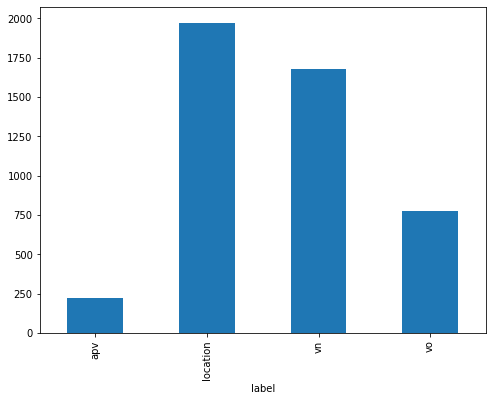

In [9]:
# Display the distribution of labels within our data

fig = plt.figure(figsize=(8,6))
df.groupby('label').text.count().plot.bar(ylim=0)
#plt.show()

### Vectorisation

In [10]:
# We vectorise with the tf-idf method (word frequency)

french_stopwords = set(stopwords.words('french'))

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.7, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words=french_stopwords)
features = tfidf.fit_transform(df.text).toarray()
labels = df.category_id
print(features.shape)

(4653, 15580)


In [11]:
# Display the n-grams most present in our document corpusd
# N = 2
# for theme, category_id in sorted(category_to_id.items()):
#     features_chi2 = chi2(features, labels == category_id)
#     indices = np.argsort(features_chi2[0])
#     feature_names = np.array(tfidf.get_feature_names_out())[indices]
#     unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
#     bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
#     print("# '{}':".format(theme))
#     print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
#     print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

### Training

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], random_state = 0)

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

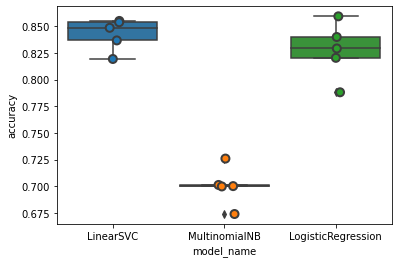

In [13]:
models = [
#     RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
        
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)

sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

### Evaluate the best model

In [14]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC             0.842680
LogisticRegression    0.827413
MultinomialNB         0.700403
Name: accuracy, dtype: float64

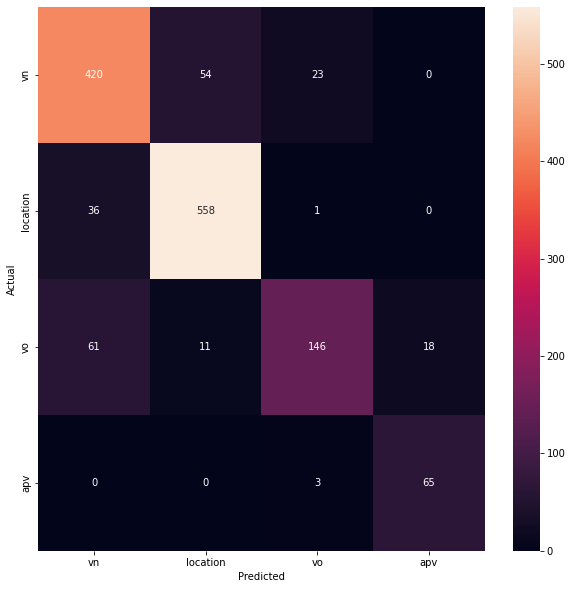

In [15]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.30, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.label.values, yticklabels=category_id_df.label.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [16]:
score = model.score(X_test, y_test)
print("Score: ", score)

Score:  0.8517191977077364


In [17]:
cv_scores = cross_val_score(model, X_test, y_test, cv=10)
print("CV average score: %.2f" % cv_scores.mean())

CV average score: 0.82


In [18]:
cv_scores = cross_val_score(model, X_train, y_train, cv=10)
print("CV average score: %.2f" % cv_scores.mean())

CV average score: 0.84


In [19]:
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.81      0.85      0.83       497
           1       0.90      0.94      0.92       595
           2       0.84      0.62      0.71       236
           3       0.78      0.96      0.86        68

    accuracy                           0.85      1396
   macro avg       0.83      0.84      0.83      1396
weighted avg       0.85      0.85      0.85      1396



In [20]:
# cv_df

### Test a prediction

In [21]:
test_msg = "Je souhaiterais acheter un véhicule d'occasion"

In [22]:
features_test = tfidf.transform([test_msg]).toarray()

In [23]:
model.predict(features_test)

array([2], dtype=int64)

In [24]:
id_to_category

{0: 'vn', 1: 'location', 2: 'vo', 3: 'apv'}

In [25]:
def classify_message(model, message: str):
    """
    input: the model and the message
    output: dict (label predicted and probability)
    predicts the class of a message with the trained model
    """
    message = tfidf.transform([message]).toarray()
    prob = model._predict_proba_lr(message)[0].tolist()
    print(prob)
    p = max(prob)
    max_index = prob.index(p)
    label = id_to_category[max_index]
    print(label)
    return {'label': label, 'probabilité': p}

In [26]:
classify_message(model, features_test)

[0.08464179212760005, 0.20225009725384693, 0.5355613625246766, 0.17754674809387636]
vo


{'label': 'vo', 'probabilité': 0.5355613625246766}

## Save the model

In [27]:
dump(model, '../output/model_svc.joblib')

and the tfidf vectorizer...

In [28]:
pickle.dump(tfidf, open("../output/tfidf.pkl", "wb"))